In [3]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [4]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('.././Dataset/AAPL.csv')
df1=df.reset_index()['Open']

In [5]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [6]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [7]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [8]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [9]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [10]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [11]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
14/14 [==============================] - 11s 252ms/step - loss: 0.0367 - val_loss: 0.0557
Epoch 2/100
14/14 [==============================] - 2s 141ms/step - loss: 0.0049 - val_loss: 0.0059
Epoch 3/100
14/14 [==============================] - 2s 147ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 4/100
14/14 [==============================] - 2s 173ms/step - loss: 0.0012 - val_loss: 0.0041
Epoch 5/100
14/14 [==============================] - 2s 152ms/step - loss: 0.0012 - val_loss: 0.0037
Epoch 6/100
14/14 [==============================] - 2s 160ms/step - loss: 0.0011 - val_loss: 0.0038
Epoch 7/100
14/14 [==============================] - 2s 161ms/step - loss: 0.0011 - val_loss: 0.0035
Epoch 8/100
14/14 [==============================] - 3s 186ms/step - loss: 0.0011 - val_loss: 0.0034
Epoch 9/100
14/14 [==============================] - 2s 176ms/step - loss: 0.0011 - val_loss: 0.0033
Epoch 10/100
14/14 [==============================] - 2s 178ms/step - loss: 0.0010 - val_l

In [12]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

2/2 [==============================] - 0s 27ms/step


In [13]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [14]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 163.24585761441543
Testing RMSE: 151.7129581500201


In [15]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [17]:

from numpy import array

lst_output=[]

n_steps=78
i=0

while(i<30):
    
    if(len(temp_input)>78):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        x_input
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
# 

0 day input [0.78183923 0.80393495 0.80325294 0.77379209 0.78395331 0.79193229
 0.79868379 0.80141161 0.79350088 0.77883857 0.76976841 0.7780884
 0.75776586 0.7618577  0.7573567  0.75585637 0.73914824 0.76410809
 0.8033211  0.80270736 0.79663787 0.80175261 0.77890683 0.7625396
 0.78620381 0.78559006 0.79220514 0.81893817 0.81205035 0.82739457
 0.84089746 0.83769222 0.8378968  0.84526203 0.83182731 0.84137478
 0.85610526 0.86231117 0.87479115 0.89068095 0.87799639 0.86224291
 0.85535509 0.86169742 0.85399118 0.85678727 0.87697338 0.88038321
 0.88727113 0.88522521 0.88720286 0.88011047 0.87976947 0.88106521
 0.86653932 0.88106521 0.90357009 0.90895758 0.91448148 0.91045791
 0.8790193  0.92055097 0.93078045 0.9346677  0.93446312 0.94012345
 0.93855485 0.93541787 0.92743888 0.92552939 0.9343267  0.95744532
 0.94100993 0.93521329 0.92130113 0.93030313 0.93650904 0.96133258]
0 day output [[0.91077757]]
1 day input [0.80393495 0.80325294 0.77379209 0.78395331 0.79193229 0.79868379
 0.80141161

In [ ]:
lst_output

[[0.8939722180366516],
 [0.8954422473907471],
 [0.8928778171539307],
 [0.8875322937965393],
 [0.8806883096694946],
 [0.873278021812439],
 [0.8658665418624878],
 [0.8587563633918762],
 [0.8520935773849487],
 [0.8459412455558777],
 [0.8403193950653076],
 [0.8352252840995789],
 [0.8306394219398499],
 [0.8265304565429688],
 [0.8228563666343689],
 [0.81956946849823],
 [0.8166155815124512],
 [0.813940167427063],
 [0.8114885687828064],
 [0.8092095851898193],
 [0.8070559501647949],
 [0.8049870729446411],
 [0.8029672503471375],
 [0.8009682893753052],
 [0.7989682555198669],
 [0.7969516515731812],
 [0.7949087619781494],
 [0.7928345203399658],
 [0.7907283306121826],
 [0.788593053817749]]

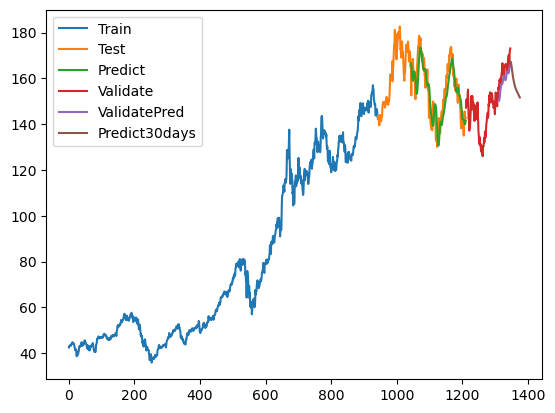

In [ ]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

In [ ]:
scaler.inverse_transform(lst_output)

array([[167.08262056],
       [167.29817832],
       [166.92214308],
       [166.13830223],
       [165.13473457],
       [164.04812697],
       [162.96134456],
       [161.9187435 ],
       [160.94174583],
       [160.03959862],
       [159.21523854],
       [158.46826355],
       [157.79581562],
       [157.19329745],
       [156.65454726],
       [156.17257293],
       [155.73942969],
       [155.34712033],
       [154.98763015],
       [154.65345138],
       [154.33765309],
       [154.03428327],
       [153.73810657],
       [153.44498892],
       [153.15171394],
       [152.85600921],
       [152.55645008],
       [152.25229365],
       [151.9434525 ],
       [151.63034618]])